In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/villarreal/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [5]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON_PAU = '2223'
SEASON_LOGAN = '2324'
MIN_MINUTES = 800

VILLARREAL_COLORS = {
    'primary': '#FFE500',
    'secondary': '#005187'
}

TOULOUSE_COLORS = {
    'primary': '#330066',
    'secondary': '#FF0066'
}

DF_PLAYERS = [
    {'name': 'Pau Torres', 'search': 'Pau Torres', 'pos': 'DF', 'team': 'Villarreal', 'season': '2223'},
    {'name': 'Logan Costa', 'search': 'Costa', 'pos': 'DF', 'team': 'Toulouse', 'season': '2324'},
]

SAVE_PATH_BASE = "./pau_torres_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [6]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)

# Query para Pau Torres (temporada 2223)
query_pau = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON_PAU}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_pau_raw = pd.read_sql(query_pau, db.engine)
print(f"Season {SEASON_PAU} (Pau): {df_pau_raw.shape[0]} registros")

# Query para Logan Costa (temporada 2324)
query_logan = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON_LOGAN}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_logan_raw = pd.read_sql(query_logan, db.engine)
print(f"Season {SEASON_LOGAN} (Logan): {df_logan_raw.shape[0]} registros")

db.close()

2025-12-06 10:14:10,403 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-06 10:14:10,484 - database.connection - INFO - Database connection successful


Season 2223 (Pau): 2095 registros
Season 2324 (Logan): 2184 registros


In [7]:
# Filtrar por minutos mínimos - AMBAS TEMPORADAS
df_pau_filtered = df_pau_raw[
    df_pau_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

df_logan_filtered = df_logan_raw[
    df_logan_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min:")
print(f"  Season {SEASON_PAU}: {df_pau_filtered.shape[0]} jugadores")
print(f"  Season {SEASON_LOGAN}: {df_logan_filtered.shape[0]} jugadores")

Filtro 800+ min:
  Season 2223: 1258 jugadores
  Season 2324: 1300 jugadores


In [8]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [9]:
# Extraer métricas - TEMPORADA PAU
fbref_nums_pau = extract_metrics(df_pau_filtered, 'fbref_metrics')
understat_nums_pau = extract_metrics(df_pau_filtered, 'understat_metrics')
print(f"Season {SEASON_PAU} - FBref: {fbref_nums_pau.shape[1]} | Understat: {understat_nums_pau.shape[1]}")

# Extraer métricas - TEMPORADA LOGAN
fbref_nums_logan = extract_metrics(df_logan_filtered, 'fbref_metrics')
understat_nums_logan = extract_metrics(df_logan_filtered, 'understat_metrics')
print(f"Season {SEASON_LOGAN} - FBref: {fbref_nums_logan.shape[1]} | Understat: {understat_nums_logan.shape[1]}")

Season 2223 - FBref: 185 | Understat: 10
Season 2324 - FBref: 185 | Understat: 10


In [10]:
# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Per90 - TEMPORADA PAU
fbref_per90_pau = fbref_nums_pau.loc[:, ~fbref_nums_pau.columns.isin(exclude_per90)]
fbref_per90_pau = (fbref_per90_pau.div(fbref_nums_pau['minutes_played'], axis=0) * 90).round(3)
fbref_per90_pau.columns = [f'{col}_per90' for col in fbref_per90_pau.columns]

understat_per90_pau = understat_nums_pau.loc[:, ~understat_nums_pau.columns.isin(exclude_per90)]
understat_per90_pau = (understat_per90_pau.div(fbref_nums_pau['minutes_played'], axis=0) * 90).round(3)
understat_per90_pau.columns = [f'{col}_per90' for col in understat_per90_pau.columns]

all_metrics_pau = pd.concat([fbref_nums_pau, understat_nums_pau, fbref_per90_pau, understat_per90_pau], axis=1)
print(f"Season {SEASON_PAU} - Total métricas: {all_metrics_pau.shape[1]}")

# Per90 - TEMPORADA LOGAN
fbref_per90_logan = fbref_nums_logan.loc[:, ~fbref_nums_logan.columns.isin(exclude_per90)]
fbref_per90_logan = (fbref_per90_logan.div(fbref_nums_logan['minutes_played'], axis=0) * 90).round(3)
fbref_per90_logan.columns = [f'{col}_per90' for col in fbref_per90_logan.columns]

understat_per90_logan = understat_nums_logan.loc[:, ~understat_nums_logan.columns.isin(exclude_per90)]
understat_per90_logan = (understat_per90_logan.div(fbref_nums_logan['minutes_played'], axis=0) * 90).round(3)
understat_per90_logan.columns = [f'{col}_per90' for col in understat_per90_logan.columns]

all_metrics_logan = pd.concat([fbref_nums_logan, understat_nums_logan, fbref_per90_logan, understat_per90_logan], axis=1)
print(f"Season {SEASON_LOGAN} - Total métricas: {all_metrics_logan.shape[1]}")

Season 2223 - Total métricas: 356
Season 2324 - Total métricas: 356


In [11]:
# Calcular percentiles - TEMPORADA PAU
all_percentiles_pau = all_metrics_pau.rank(pct=True) * 98 + 1
all_percentiles_pau = all_percentiles_pau.round(0).astype('Int64')
all_percentiles_pau.columns = [f'{col}_pct' for col in all_percentiles_pau.columns]
print(f"Season {SEASON_PAU} - Percentiles: {all_percentiles_pau.shape[1]}")

# Calcular percentiles - TEMPORADA LOGAN
all_percentiles_logan = all_metrics_logan.rank(pct=True) * 98 + 1
all_percentiles_logan = all_percentiles_logan.round(0).astype('Int64')
all_percentiles_logan.columns = [f'{col}_pct' for col in all_percentiles_logan.columns]
print(f"Season {SEASON_LOGAN} - Percentiles: {all_percentiles_logan.shape[1]}")

Season 2223 - Percentiles: 356
Season 2324 - Percentiles: 356


In [12]:
# DataFrame final - TEMPORADA PAU
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final_pau = pd.concat([
    df_pau_filtered[base_cols],
    all_metrics_pau,
    all_percentiles_pau
], axis=1)
print(f"Season {SEASON_PAU} - DataFrame final: {df_final_pau.shape[0]} filas, {df_final_pau.shape[1]} columnas")

# DataFrame final - TEMPORADA LOGAN
df_final_logan = pd.concat([
    df_logan_filtered[base_cols],
    all_metrics_logan,
    all_percentiles_logan
], axis=1)
print(f"Season {SEASON_LOGAN} - DataFrame final: {df_final_logan.shape[0]} filas, {df_final_logan.shape[1]} columnas")

# MERGE A LO BRUTO
df_final = pd.concat([df_final_pau, df_final_logan], ignore_index=True)
print(f"\nMerge completo: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])
print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

Season 2223 - DataFrame final: 1258 filas, 718 columnas
Season 2324 - DataFrame final: 1300 filas, 718 columnas

Merge completo: 2558 filas, 718 columnas
Limpieza completada: 716 columnas finales


In [14]:
# Search DF players
player_ids = {}

print("DF PLAYER SEARCH:")
print("=" * 50)

# Buscar Pau Torres en temporada 2223
pau_results = df_final[
    (df_final['player_name'].str.contains('Pau Torres', case=False, na=False)) &
    (df_final['season'] == SEASON_PAU)
]
if len(pau_results) > 0:
    p = pau_results.iloc[0]
    player_ids['Pau Torres'] = p['unique_player_id']
    print(f"✓ Pau Torres ({SEASON_PAU}): {p['unique_player_id']} - {p['team']}")
else:
    print(f"✗ Pau Torres NOT FOUND in season {SEASON_PAU}")

# Buscar Logan Costa en temporada 2324
logan_results = df_final[
    (df_final['player_name'].str.contains('Logan Costa', case=False, na=False)) &
    (df_final['season'] == SEASON_LOGAN) &
    (df_final['position'].str.contains('DF', case=False, na=False))
]
if len(logan_results) > 0:
    for _, p in logan_results.iterrows():
        print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']})")
    
    selected = logan_results.iloc[0]
    player_ids['Logan Costa'] = selected['unique_player_id']
    print(f"✓ Logan Costa ({SEASON_LOGAN}): {selected['unique_player_id']} - {selected['team']}")
else:
    print(f"✗ Logan Costa NOT FOUND in season {SEASON_LOGAN}")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

DF PLAYER SEARCH:
✓ Pau Torres (2223): 7038310ad2ae51db - Villarreal
  3b445a031f685465 - Logan Costa (Toulouse, FRA-Ligue 1)
✓ Logan Costa (2324): 3b445a031f685465 - Toulouse

PLAYERS FOUND:
  Pau Torres: 7038310ad2ae51db
  Logan Costa: 3b445a031f685465


In [15]:
# DF metrics configuration
df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per90', 'Aerial Duels_Won%',
    'passes_final_third_per90', 'clearances_per90', 'progressive_passes_per90', 'Tkl+Int_per90',
    'interceptions_per90', 'Blocks_Sh_per90'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

print("DF METRICS VERIFICATION:")
print("=" * 50)
status = "OK" if len(df_metrics) == 10 and len(df_titles) == 10 else "ERROR"
print(f"{status} DF Central: {len(df_metrics)} metrics, {len(df_titles)} titles")

DF METRICS VERIFICATION:
OK DF Central: 10 metrics, 10 titles


In [ ]:
# DF comparison configuration
DF_COMPARISON = {
    'name': 'Pau_vs_Logan',
    'player1': 'Pau Torres',
    'player2': 'Logan Costa', 
    'position_type': 'DF_CENTRAL',
    'metrics_key': 'df_central',
    'title': 'Pau Torres (22/23) vs Logan Costa (23/24)',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/pau_torres.png', '/home/jaime/FD/data/blog/caras/tfm/costa.png'],
    'colors': [VILLARREAL_COLORS['primary'], TOULOUSE_COLORS['primary']]
}

METRICS_BY_POSITION = {
    'df_central': {'metrics': df_metrics, 'titles': df_titles}
}

print(f"COMPARISON: {DF_COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

DF PLAYER RADAR GENERATION

Processing: Pau Torres (22/23) vs Logan Costa (23/24)
  Dataset: 1014 players (DF)
  Teams: Villarreal vs Toulouse
  Colors: ['#FFE500', '#330066']
  ✓ Completed: Pau_vs_Logan_combined.png


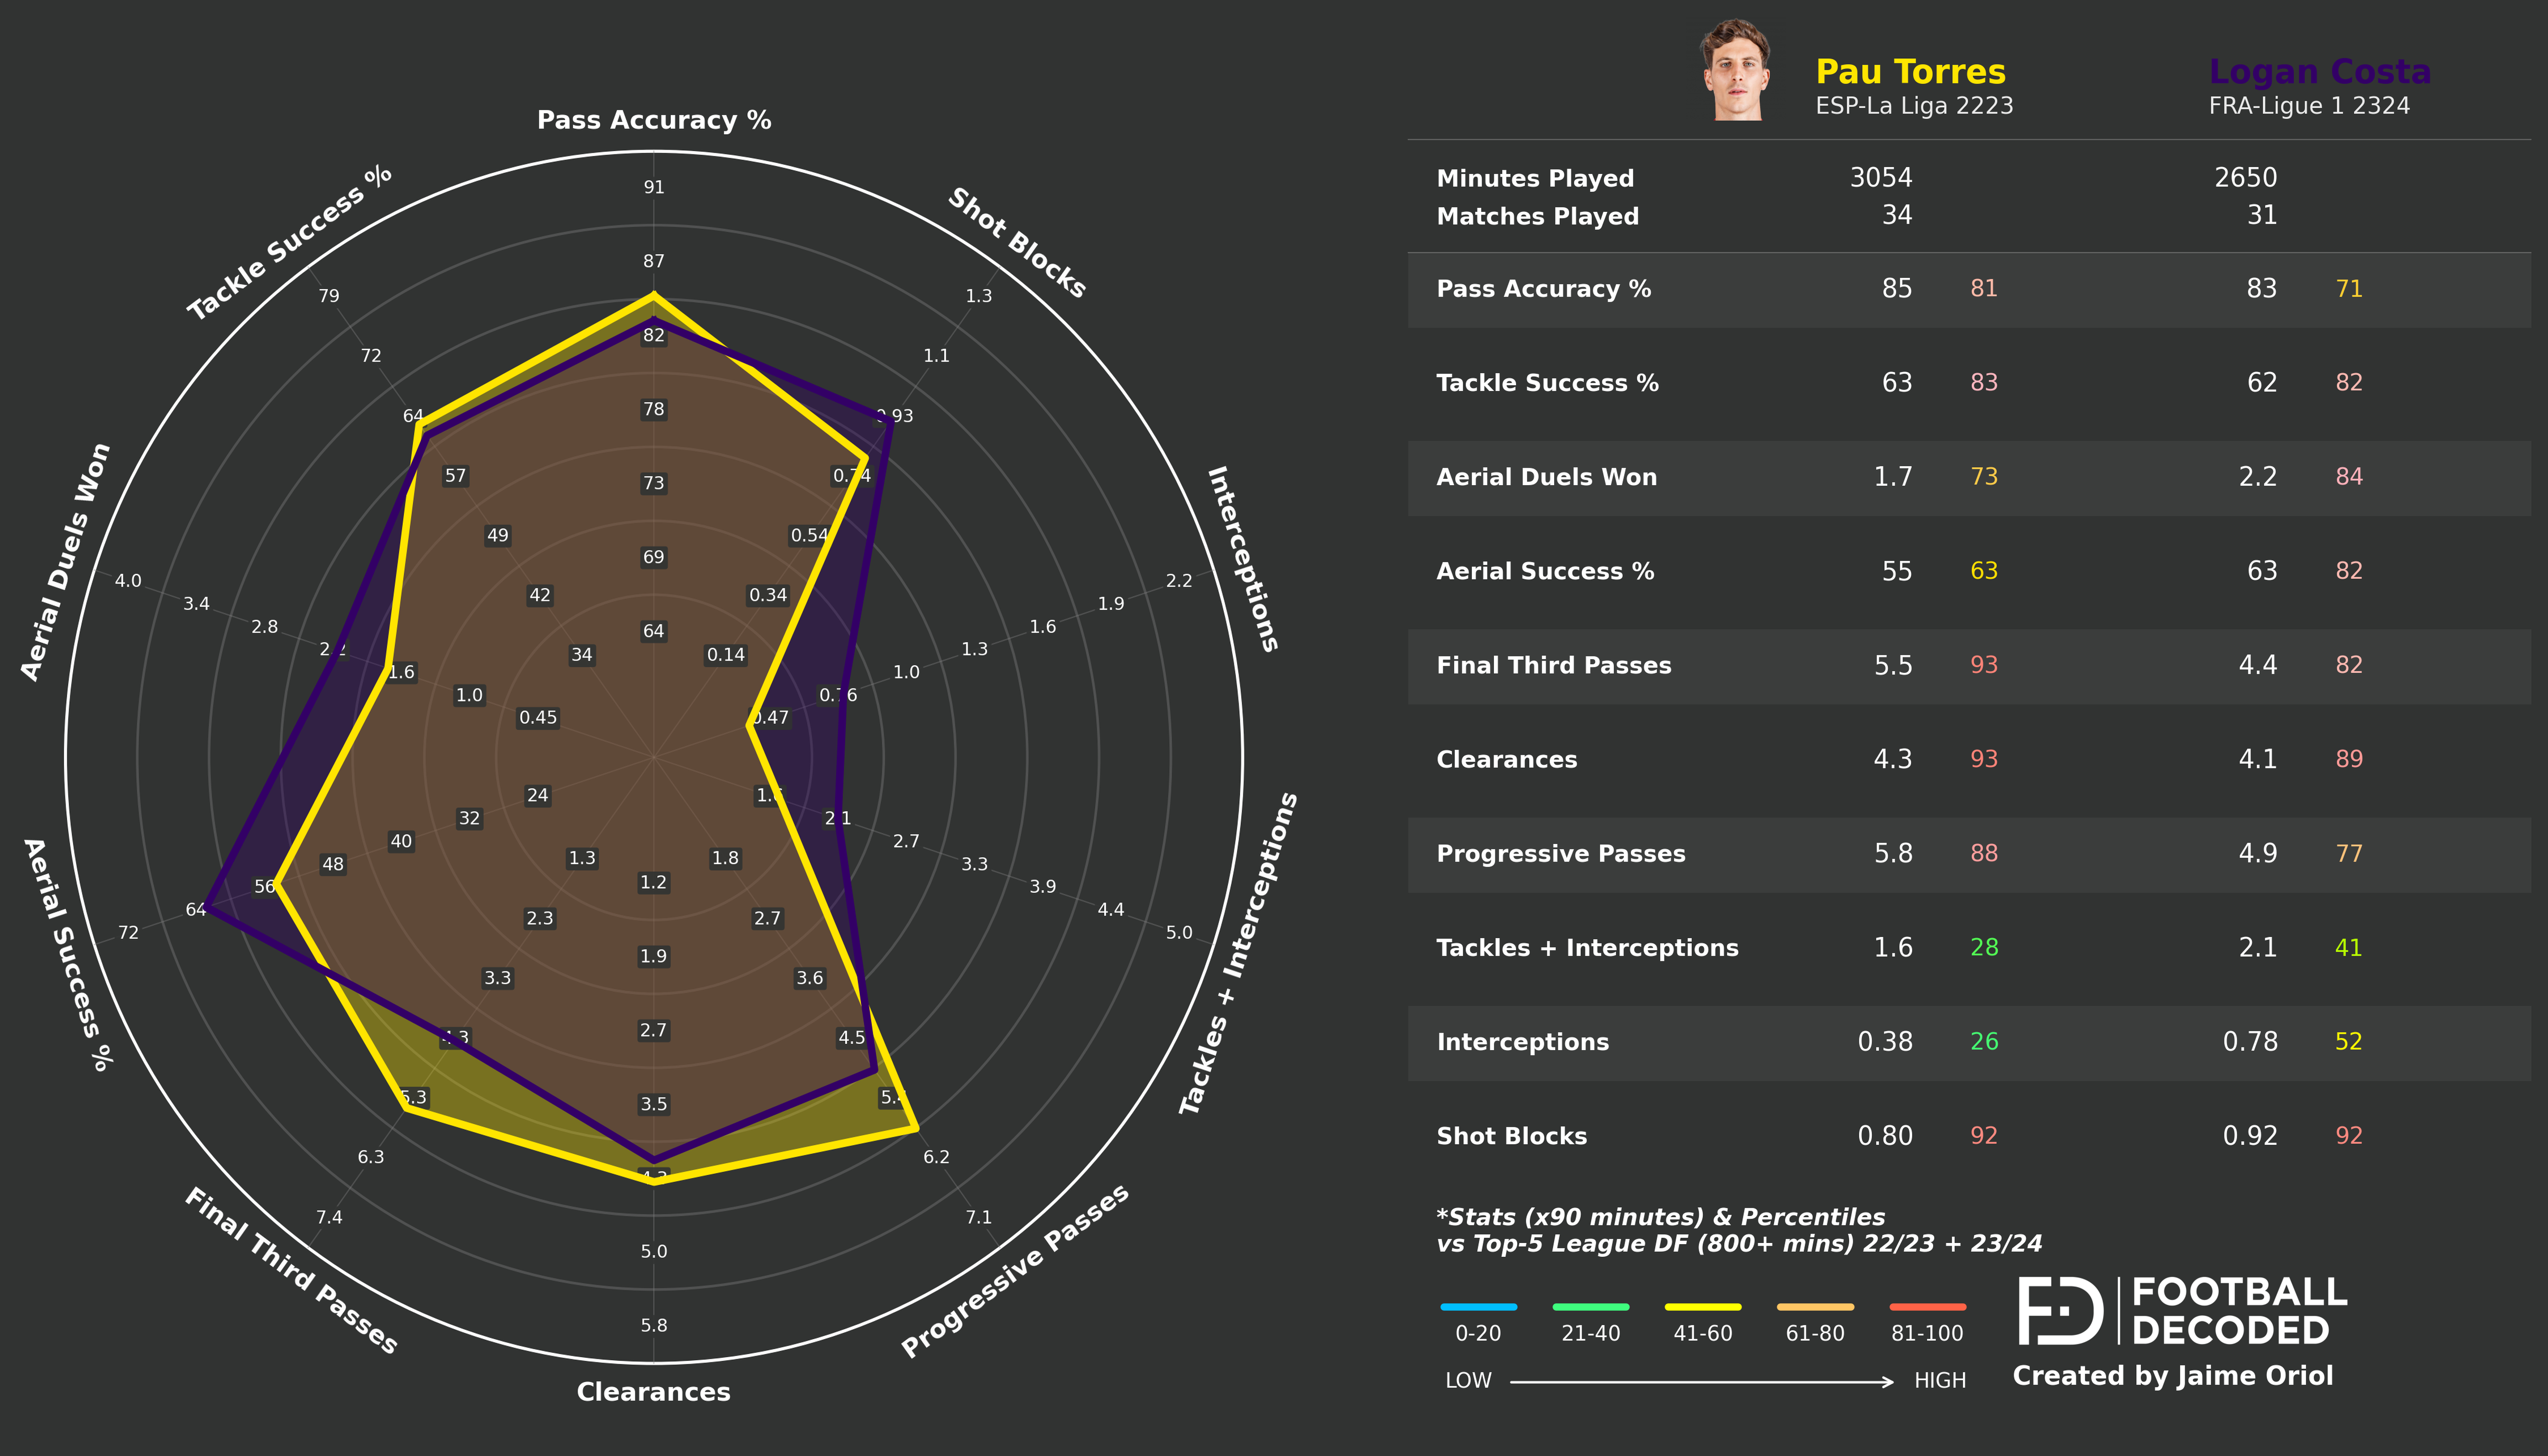


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./pau_torres_radars/


In [17]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("DF PLAYER RADAR GENERATION")
print("=" * 50)

comparison = DF_COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset DF
    position_df = df_final[df_final['position'].str.startswith('DF')].copy()
    position_filter = "DF"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {player1_team: faces[0]} if faces[0] else {}
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (x90 minutes) & Percentiles\nvs Top-5 League {position_filter} ({MIN_MINUTES}+ mins) 22/23 + 23/24",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()